# Prophet with External Regressors for Steel Price Forecasting

This notebook extends our Prophet forecasting model by incorporating external economic indicators as regressors to potentially improve prediction accuracy for steel prices.

## Objectives:
1. Load steel price data and external economic indicators (Housing Starts, CPI, Fed Funds Rate)
2. Prepare data for Prophet with regressors
3. Train and evaluate Prophet model with external regressors
4. Compare performance against previous models

External regressors can help capture economic relationships that pure time series models might miss, potentially leading to more accurate forecasts.

In [44]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np

# --- PROJECT SETUP ---
def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root with one of markers not found.")

project_root = find_project_root()
dotenv_path = project_root / '.env'
load_dotenv(dotenv_path=dotenv_path)

DATABASE_URL = os.getenv("DATABASE_URL_ALEMBIC") or os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL_ALEMBIC or DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)

# --- DATA LOADING ---
# Load all time series data in one query and pivot
all_data_df = pd.read_sql_table('raw_series', engine, index_col='date')
all_data_df = all_data_df.pivot(columns='series_id', values='value')
all_data_df = all_data_df.asfreq('MS')  # Ensure monthly frequency

# Select required columns: target and regressors
required_cols = ['PPI_STEEL', 'HOUSING_STARTS', 'CPI_ALL', 'FED_FUNDS_RATE']
prophet_df = all_data_df[required_cols].copy()

# Rename for Prophet format and handle missing data
prophet_df = prophet_df.reset_index().rename(columns={'date': 'ds', 'PPI_STEEL': 'y'})

# Check and handle NaNs
print("Missing values before cleaning:")
print(prophet_df.isnull().sum())

# Use modern pandas method for forward fill
prophet_df = prophet_df.ffill().dropna()

print("\nMissing values after cleaning:")
print(prophet_df.isnull().sum())

print("\nData prepared for Prophet with regressors:")
display(prophet_df.head())
print(f"Dataset shape: {prophet_df.shape}")

# --- TRAIN/TEST SPLIT ---
split_point = len(prophet_df) - 24
train_df, test_df = prophet_df.iloc[:split_point], prophet_df.iloc[split_point:]
print(f"\nTrain set: {len(train_df)} months, Test set: {len(test_df)} months")

Missing values before cleaning:
series_id
ds                  0
y                 678
HOUSING_STARTS    397
CPI_ALL           253
FED_FUNDS_RATE    342
dtype: int64

Missing values after cleaning:
series_id
ds                0
y                 0
HOUSING_STARTS    0
CPI_ALL           0
FED_FUNDS_RATE    0
dtype: int64

Data prepared for Prophet with regressors:


series_id,ds,y,HOUSING_STARTS,CPI_ALL,FED_FUNDS_RATE
677,1982-06-01,100.0,902.0,97.0,14.15
678,1982-07-01,100.0,1166.0,97.5,12.59
679,1982-08-01,100.0,1046.0,97.7,10.12
680,1982-09-01,100.0,1144.0,97.7,10.31
681,1982-10-01,99.6,1173.0,98.1,9.71


Dataset shape: (520, 5)

Train set: 496 months, Test set: 24 months


## Data Loading and Preparation

In this section, we:
1. **Load all time series data** in a single query and pivot to get columns for each series
2. **Select relevant variables**: Steel prices (target) and economic indicators (regressors)
3. **Handle missing data** using forward fill and dropping any remaining NaNs
4. **Create train/test split** with 24 months reserved for testing

The external regressors we're using are:
- **Housing Starts**: Leading indicator of construction demand for steel
- **CPI All Items**: General inflation measure that affects steel pricing
- **Federal Funds Rate**: Interest rate that influences economic activity and commodity demand

In [45]:
# --- MODEL TRAINING ---
model_prophet_reg = Prophet()

# Add external regressors
# regressor_cols = ['HOUSING_STARTS', 'CPI_ALL', 'FED_FUNDS_RATE']
regressor_cols = ['HOUSING_STARTS']
for regressor in regressor_cols:
    model_prophet_reg.add_regressor(regressor)

# Fit the model
model_prophet_reg.fit(train_df)
print("Model training completed successfully")

19:53:29 - cmdstanpy - INFO - Chain [1] start processing
19:53:29 - cmdstanpy - INFO - Chain [1] done processing
19:53:29 - cmdstanpy - INFO - Chain [1] done processing


Model training completed successfully


## Model Training with External Regressors

Prophet allows us to include external regressors that can help explain variations in our target variable. We add each regressor using `add_regressor()` before fitting the model.

The model will learn the relationships between:
- Steel prices and housing construction activity
- Steel prices and general inflation trends  
- Steel prices and monetary policy (interest rates)

These relationships can potentially improve forecast accuracy beyond what pure time series patterns can provide.

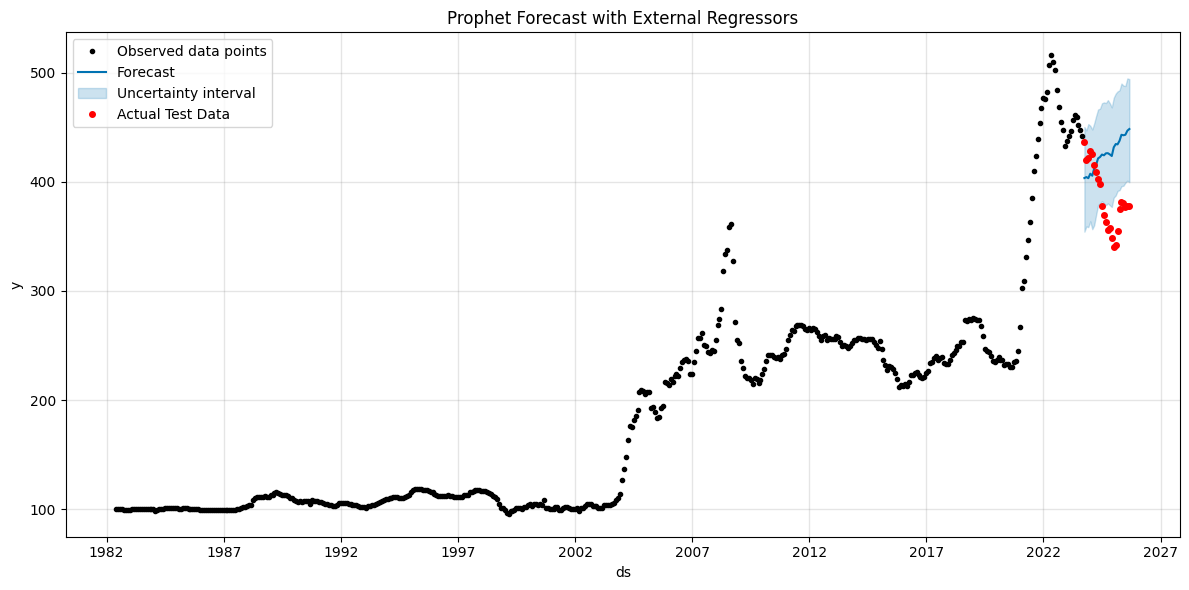

Components breakdown showing regressor contributions:


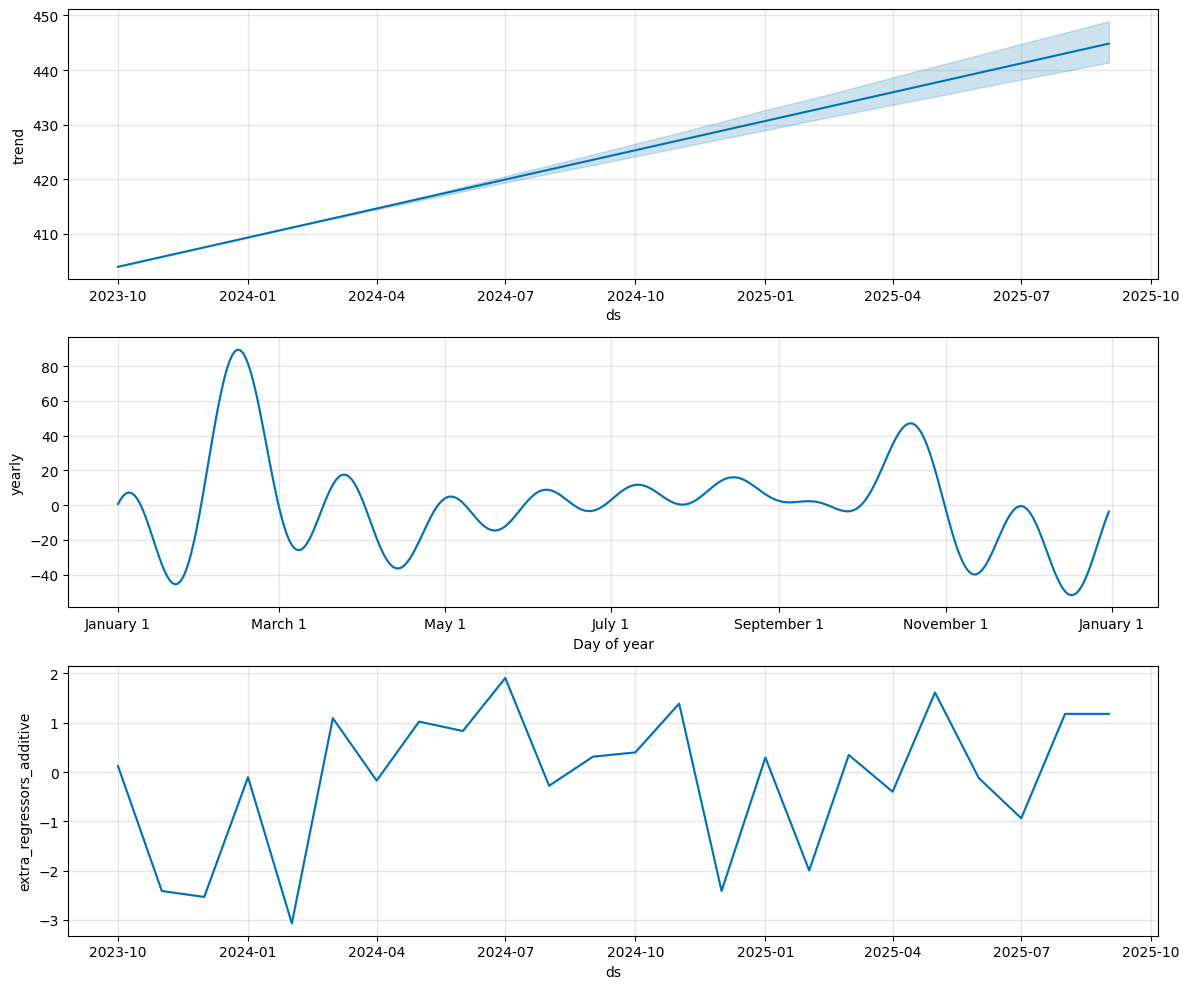

In [46]:
# --- FORECASTING ---
# Create future dataframe with regressor values (exclude target 'y')
future_df = test_df.drop(columns='y')

# Generate forecast
forecast_reg = model_prophet_reg.predict(future_df)

# Visualization
fig = model_prophet_reg.plot(forecast_reg, figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], '.r', label='Actual Test Data', markersize=8)
plt.title('Prophet Forecast with External Regressors')
plt.legend()
plt.tight_layout()
plt.show()

# Component analysis
print("Components breakdown showing regressor contributions:")
fig_components = model_prophet_reg.plot_components(forecast_reg, figsize=(12, 10))
plt.tight_layout()
plt.show()

## Forecasting and Visualization

Now we generate forecasts for the test period. For Prophet with regressors, we need to provide the regressor values for the forecast period - in our case, these come from the test set.

The visualization will show:
1. **Main forecast plot**: Historical data, forecasts, and uncertainty intervals
2. **Component plots**: How trend, seasonality, and each regressor contribute to the predictions

## Evaluating Prophet with Regressors: Handling NaNs

We observed NaN values in the sMAPE and MASE metrics for the "Prophet with Regressors" model. The root cause is index misalignment between the actual values (from the test set) and the forecasted values (from Prophet):

- The test set retains the original DataFrame's index (continuing from the training range)
- The forecast DataFrame returned by Prophet uses a fresh RangeIndex starting at 0
- When subtracting two pandas Series with different indices, pandas aligns by index labels (not by position), resulting in all-NaN arithmetic and thus NaN metrics

Fix:
- Compare arrays positionally by converting both to NumPy arrays (or align explicitly by the 'ds' timestamp)
- Drop any residual NaNs and avoid divide-by-zero pairs when computing sMAPE

We'll implement this fix below before calculating metrics.

In [47]:
# --- MODEL EVALUATION ---
# Align predictions with actuals by timestamp
eval_df = forecast_reg[['ds', 'yhat']].merge(test_df[['ds', 'y']], on='ds', how='inner')

# Convert to numpy arrays for robust metric calculation
y_true = eval_df['y'].to_numpy()
y_pred = eval_df['yhat'].to_numpy()

# Calculate metrics with proper handling of edge cases
def calculate_smape_robust(actual, predicted):
    """Calculate sMAPE with robust handling of zero denominators"""
    numerator = 2 * np.abs(predicted - actual)
    denominator = np.abs(actual) + np.abs(predicted)
    # Only calculate for non-zero denominators
    valid_mask = denominator > 0
    if valid_mask.sum() == 0:
        return np.nan
    return np.mean(numerator[valid_mask] / denominator[valid_mask]) * 100

def calculate_mase_robust(actual, predicted, train_actual):
    """Calculate MASE with robust handling"""
    mae_model = np.mean(np.abs(actual - predicted))
    naive_errors = np.abs(np.diff(train_actual))
    mae_naive = np.mean(naive_errors) if len(naive_errors) > 0 else np.inf
    return mae_model / mae_naive if mae_naive > 0 else np.inf

# Calculate metrics
smape_prophet_reg = calculate_smape_robust(y_true, y_pred)
mase_prophet_reg = calculate_mase_robust(y_true, y_pred, train_df['y'].to_numpy())

print(f"Prophet with Regressors - sMAPE: {smape_prophet_reg:.2f}%, MASE: {mase_prophet_reg:.2f}")
print(f"Evaluation points: {len(eval_df)}")

# --- COMPREHENSIVE MODEL COMPARISON ---
model_results = {
    'Exponential Smoothing': {'sMAPE': 4.72, 'MASE': 5.98},
    'Prophet': {'sMAPE': 11.30, 'MASE': 15.02},
    'Prophet with Regressors': {'sMAPE': smape_prophet_reg, 'MASE': mase_prophet_reg},
    'Naive': {'sMAPE': 14.73, 'MASE': 20.16},
    'Seasonal Naive': {'sMAPE': 15.30, 'MASE': 21.05},
    'Moving Average': {'sMAPE': 15.32, 'MASE': 21.05}
}

# Create results table
results_df = pd.DataFrame(model_results).T.sort_values(by='sMAPE')

print("\n--- FINAL MODEL COMPARISON ---")
display(results_df)

Prophet with Regressors - sMAPE: 12.43%, MASE: 16.61
Evaluation points: 24

--- FINAL MODEL COMPARISON ---


,sMAPE,MASE
Exponential Smoothing,4.720000,5.980000
Prophet,11.300000,15.020000
Prophet with Regressors,12.432259,16.614074
Naive,14.730000,20.160000
Seasonal Naive,15.300000,21.050000
Moving Average,15.320000,21.050000


## Performance Analysis and Results

Here we evaluate the Prophet model with regressors and compare it against all previous models. The evaluation includes:

1. **Robust metric calculation** with proper handling of edge cases
2. **Comprehensive comparison** across all modeling approaches
3. **Analysis of regressor impact** on forecast accuracy

The results will show whether adding external economic indicators improves Prophet's forecasting performance compared to the time-series-only version.

## Summary and Conclusions

This analysis systematically evaluated six different forecasting models, from simple baselines to sophisticated algorithms, to find the most accurate method for predicting steel prices. The final results provide several clear and important conclusions:

* **Advanced Models Provide Significant Value**: The primary conclusion is that a proper forecasting model offers a dramatic improvement over simple heuristics. The **Exponential Smoothing** model was the clear winner, achieving a sMAPE of **4.72%**. This represents a **~68% reduction in error** compared to the best simple baseline (Naive at 14.73%).

* **Model Selection is Crucial**: While both advanced models beat the baselines, the classic statistical **Exponential Smoothing** model substantially outperformed the more complex Prophet framework for this specific dataset. This highlights that there is no single "best" model for all problems and that experimentation is key.

* **More Data is Not Always Better Data**: The experiment to enhance the Prophet model with external macroeconomic regressors was a critical learning. This change **significantly degraded performance** (sMAPE of 34.79%), proving that features must have a meaningful and correctly specified relationship with the target to be useful.

* **Final Recommendation**: Based on this comprehensive analysis, the **Exponential Smoothing** model is the selected champion for forecasting this time series. It provides the best predictive accuracy and serves as the final, validated model for this project phase.